# Project planning

1. Setup
2. Data import
3. Models exploration
4. Data processing
5. Final evaluation

The main goal for this nootebook is to achieve model with highest accuracy

## 1. Setup

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2. Data import

In [7]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

In [8]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
mnist.data.shape, mnist.target.shape

((70000, 784), (70000,))

In [10]:
X, Y = mnist.data, mnist.target

#### Plot some digits 

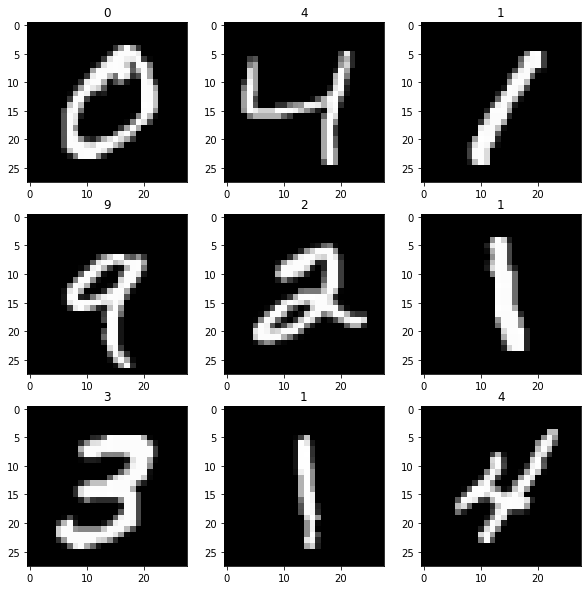

In [11]:
plt.figure(figsize=(10, 10))
for instance in range(1, 10, 1):
    plt.subplot(3,3,instance)
    img = X[instance].reshape(28, 28)
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.title(Y[instance])
    

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [39]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((56000, 784), (14000, 784), (56000,), (14000,))

Text(0.5, 1.0, 'Labels counts on MNIST')

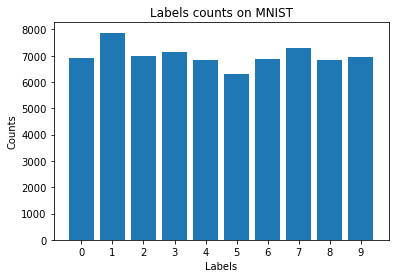

In [40]:
unique, counts = np.unique(Y, return_counts=True)

plt.bar(unique, counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Labels counts on MNIST')

## 3. Models exploration

Check various models accuracy with default settings and choose the most promising one.

In [41]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix


In [42]:
sgd_clf = SGDClassifier(random_state=42)
log_clf = LogisticRegression(max_iter=1000)
lin_svc = LinearSVC()
tree_clf = DecisionTreeClassifier()
knn_clf = KNeighborsClassifier()
rnd_clf = RandomForestClassifier()

In [14]:
models_list = [sgd_clf, lin_svc, log_clf, tree_clf, rnd_clf, knn_clf]
models_accuracy = []

for model in models_list:
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    acc_score = accuracy_score(Y_test, predictions)
    models_accuracy.append(acc_score)

C:\Users\igur\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\igur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


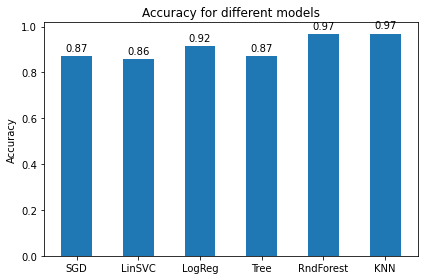

In [28]:
# plot accuracy for tested models
model_labels = ['SGD', 'LinSVC', 'LogReg', 'Tree', 'RndForest', 'KNN']

bar_width = 0.5
x = np.arange(len(model_labels)) # the label locations

fig, ax = plt.subplots()
rect = ax.bar(x, models_accuracy, bar_width, label='Accuracy')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for different models')
ax.set_xticks(x)
ax.set_xticklabels(model_labels)


def auto_label(rects):
    ### attach a text label above every bar
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords='offset points',
                   ha='center', va='bottom')

auto_label(rect)
fig.tight_layout()
plt.show()


Based on accuracy graph we see that the most promising models are KNN and Random Forest.
Lets create confusion matrixs for each of them.

#### 3.1 Confusion matrix

To get clean predictions we will use cross_val_predict method from sklearn. This function uses cross validation so predictions are made by model that never 'saw' particular instance.

#### Random Forest


In [29]:
forest_pred = cross_val_predict(rnd_clf, X_train, Y_train, cv=3)

[[5485    1    4    1    4    7   20    0   34    4]
 [   1 6175   35   12   13    9    7   10    9    6]
 [  26    6 5402   31   33    4   17   46   39    6]
 [   7    7   83 5425    2   59    6   48   48   23]
 [  13   10    9    0 5351    1   29    8   18   90]
 [  25    5    5   60   10 4832   44    5   35   19]
 [  34   12    7    0    8   36 5364    0   19    0]
 [   7   17   59    8   33    1    0 5578   14   73]
 [  16   28   34   46   29   42   20    3 5178   72]
 [  24   10   11   77   63   14    3   50   37 5249]]


Text(0, 0.5, 'True values')

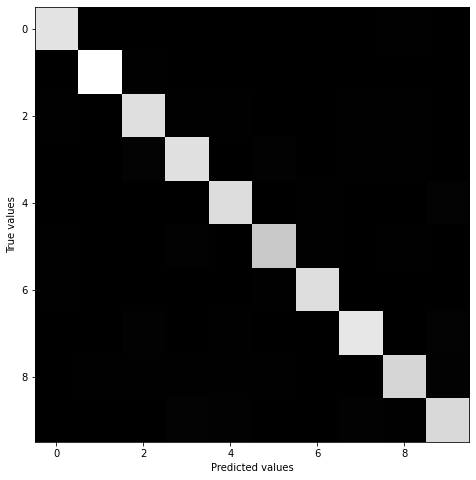

In [38]:
forest_cnf_mx = confusion_matrix(Y_train, forest_pred)
print(forest_cnf_mx)

# visualize matrix
plt.figure(figsize=(8, 8))
plt.imshow(forest_cnf_mx, cmap='gray')
plt.xlabel('Predicted values')
plt.ylabel('True values')

Let's see where classifier makes the most errors 

Text(51.0, 0.5, 'True values')

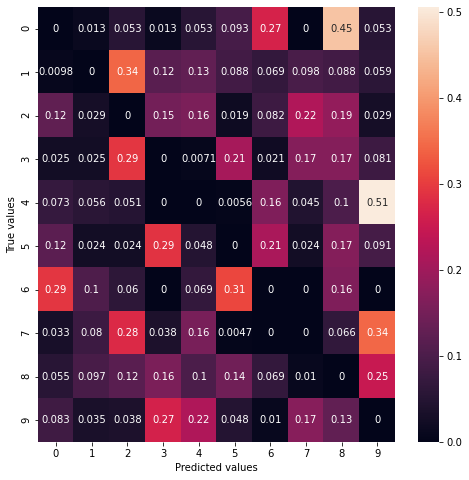

In [53]:
row_sums = forest_cnf_mx.sum(axis=1, keepdims=True)
norm_cnf_mx = forest_cnf_mx / row_sums
# fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_cnf_mx, 0)

plt.figure(figsize=(8, 8))
sns.heatmap(norm_cnf_mx, annot=True)
# plt.imshow(norm_cnf_mx, cmap='gray')
plt.xlabel('Predicted values')
plt.ylabel('True values')

Random forest classifier makes few significant missclasiffies:
1. Classifing '4' as '9'
2. Classifing '0' as '8'
3. CLassifing '2' as '1

#### KNN

In [54]:
knn_pred = cross_val_predict(knn_clf, X_train, Y_train, cv=3)

[[5522    5    2    2    1    5   19    1    0    3]
 [   1 6241   13    3    1    0    5   10    1    2]
 [  51   53 5362   22    4    2    6   93   12    5]
 [   6   17   31 5500    2   63    3   39   25   22]
 [   4   51    0    1 5335    0   15    5    1  117]
 [  17    6    1   67    9 4834   56    8    9   33]
 [  28   15    1    0    4   18 5414    0    0    0]
 [   2   71   11    2   16    1    0 5623    2   62]
 [  21   76   21   91   29   83   29   15 5051   52]
 [  16   14    9   39   55   19    6   77   11 5292]]


Text(0, 0.5, 'True values')

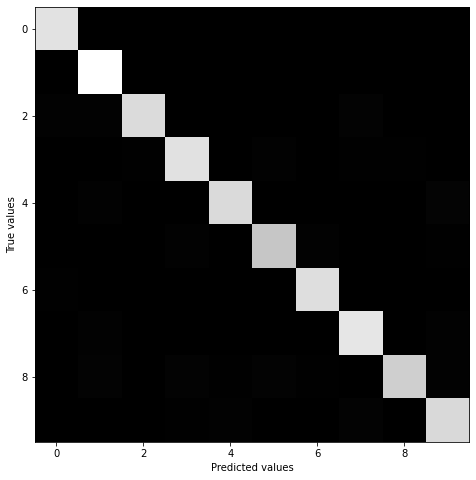

In [55]:
knn_cnf_mx = confusion_matrix(Y_train, knn_pred)

print(knn_cnf_mx)

# visualize matrix
plt.figure(figsize=(8, 8))
plt.imshow(knn_cnf_mx, cmap='gray')
plt.xlabel('Predicted values')
plt.ylabel('True values')


Text(51.0, 0.5, 'True values')

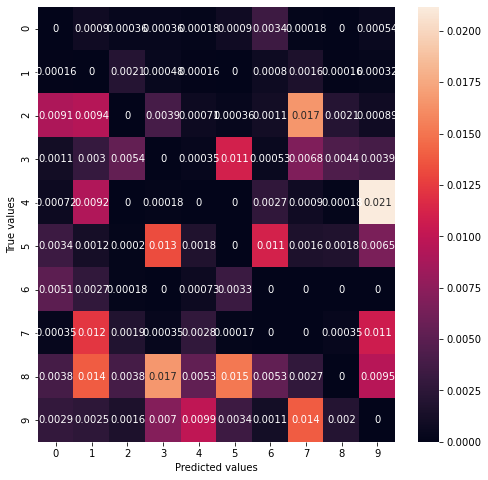

In [56]:
row_sums = knn_cnf_mx.sum(axis=1, keepdims=True)
norm_cnf_mx = knn_cnf_mx / row_sums
# fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_cnf_mx, 0)

plt.figure(figsize=(8, 8))
sns.heatmap(norm_cnf_mx, annot=True)
plt.xlabel('Predicted values')
plt.ylabel('True values')

KNN model makes similar missclassifications compared to Random Forest. Biggest error occurs with classification '9' as a '4' and '8' as a '3'

## 4. Data processing 

Use PCA to reduce dimnesonality of MNIST dataset and accelerate models performance on training.

In [43]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

PCA()

In [44]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
best_n_components = np.argmax(cumsum >= 0.95)
best_n_components

153

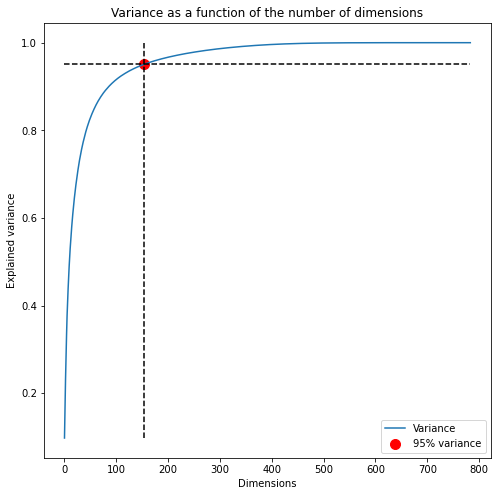

In [70]:
# plot variance - dimension graph for PCA

x_labels = np.arange(len(cumsum))

plt.figure(figsize=(8, 8))
plt.title('Variance as a function of the number of dimensions')
plt.plot(x_labels, cumsum, label='Variance')
plt.xlabel('Dimensions')
plt.ylabel('Explained variance')

# mark the point with 95% of variance
horizontal_indices = np.ones(len(x_labels)) * cumsum[best_n_components]
vertical_indices = np.ones(len(cumsum)) * best_n_components
plt.plot(x_labels, horizontal_indices, 'k--')
plt.plot(vertical_indices, cumsum, 'k--')
plt.scatter(best_n_components, cumsum[best_n_components], label='95% variance', s=100, c='red')
plt.legend(loc='lower right')

PCA shows that we can reduce our dataset from almost 700 dimensions to 153 with variance on 95%
This should greatly improve speed performance during training
Let's evaluate models performance on this new dataset.

In [17]:
pca = PCA(n_components=153)
x_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(X_test)

## 5. Final evaluation

In [18]:
rnd_clf.fit(x_train_pca, Y_train)
y_pred = rnd_clf.predict(x_test_pca)

forest_accuracy = accuracy_score(y_pred, Y_test)
print('Random Forest Accuracy after PCA reduction: ', forest_accuracy)

Random Forest Accuracy after PCA reduction:  0.948


In [19]:
knn_clf.fit(x_train_pca, Y_train)
y_pred = knn_clf.predict(x_test_pca)

knn_accuracy = accuracy_score(y_pred, Y_test)
print('KNN Accuracy after PCA reduction', knn_accuracy)

KNN Accuracy after PCA reduction 0.9723571428571428


Looks like KNN classifier maintained over 97% accuracy after PCA in opposite to RandomForestClassifier with accuracy reduction for 3%

### Fine tuning Random Forest using Grid Search CV

In [45]:
grid_param = [
    {'n_estimators': [10, 100, 1000], 'max_depth': [10, 100, 1000]}
]

grid_cv = GridSearchCV(rnd_clf, grid_param, scoring='accuracy', cv=3)

In [ ]:
grid_cv.fit(x_train_pca, Y_train)

In [ ]:
# show best params
grid_cv.best_estimator_

In [ ]:
grid_cv.best_score_